In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv(r'/content/drive/MyDrive/Deep Learning Project./CarCS1.csv')
data.head()

,Timestamp,Arbitration_ID,DLC,D0,D1,D2,D3,D4,D5,D6,D7,Class,SubClass
0,1.597759e+09,854,8,0,0,0.0,128.0,22.0,0.0,0.0,0.0,Normal,Normal
1,1.597759e+09,870,7,49,234,10.0,49.0,48.0,0.0,1.0,NaN,Normal,Normal
2,1.597759e+09,871,8,0,0,0.0,0.0,0.0,0.0,197.0,10.0,Normal,Normal
3,1.597759e+09,872,8,0,0,0.0,0.0,0.0,228.0,10.0,64.0,Normal,Normal
4,1.597759e+09,608,8,5,49,2.0,48.0,0.0,189.0,79.0,22.0,Normal,Normal


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312119 entries, 0 to 3312118
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration_ID  int64  
 2   DLC             int64  
 3   D0              int64  
 4   D1              int64  
 5   D2              float64
 6   D3              float64
 7   D4              float64
 8   D5              float64
 9   D6              float64
 10  D7              float64
 11  Class           object 
 12  SubClass        object 
dtypes: float64(7), int64(4), object(2)
memory usage: 328.5+ MB


In [ ]:
data.isnull().sum()

Timestamp              0
Arbitration_ID         0
DLC                    0
D0                     0
D1                     0
D2                  5076
D3                  5076
D4                260174
D5                323584
D6                457045
D7                588023
Class                  0
SubClass               0
dtype: int64

In [ ]:
import statistics
for i in ('D2','D3','D4','D5','D6','D7'):
  m=statistics.mode(data[i])
  data[i]=data[i].fillna(m)
data.isnull().sum()

Timestamp         0
Arbitration_ID    0
DLC               0
D0                0
D1                0
D2                0
D3                0
D4                0
D5                0
D6                0
D7                0
Class             0
SubClass          0
dtype: int64

In [ ]:
for i in data.columns:
  if data[i].dtype=='object':
    data[i]=LabelEncoder().fit_transform(data[i])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312119 entries, 0 to 3312118
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration_ID  int64  
 2   DLC             int64  
 3   D0              int64  
 4   D1              int64  
 5   D2              float64
 6   D3              float64
 7   D4              float64
 8   D5              float64
 9   D6              float64
 10  D7              float64
 11  Class           int64  
 12  SubClass        int64  
dtypes: float64(7), int64(6)
memory usage: 328.5 MB


In [ ]:
corr=data.corr()
print('correlation of input features with class',corr['Class'])
print('correlation of input features with subclass',corr['SubClass'])

correlation of input features with class Timestamp        -0.002028
Arbitration_ID    0.283307
DLC              -0.105086
D0                0.044855
D1                0.060482
D2               -0.010307
D3                0.090264
D4               -0.006933
D5                0.077482
D6                0.000398
D7                0.050168
Class             1.000000
SubClass          0.673914
Name: Class, dtype: float64
correlation of input features with subclass Timestamp         0.013192
Arbitration_ID    0.411829
DLC              -0.106092
D0                0.078727
D1                0.114319
D2                0.077346
D3                0.132142
D4                0.053879
D5                0.107520
D6                0.070116
D7                0.094972
Class             0.673914
SubClass          1.000000
Name: SubClass, dtype: float64


In [ ]:
y=data['Class']
y1=data['SubClass']
x=data.drop(['Class','SubClass'],axis=1)

In [ ]:
x=StandardScaler().fit_transform(x)

In [ ]:
from tensorflow.keras.utils import to_categorical
y1=to_categorical(y1,num_classes=5)

In [ ]:
x_train,x_test,y_train,y_test,y_train1,y_test1= train_test_split(x,y,y1,test_size=0.2,stratify=y1)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,y_train1.shape,y_test1.shape

((2649695, 11), (662424, 11), (2649695,), (662424,), (2649695, 5), (662424, 5))

In [ ]:
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,1), name='input')
main_branch=tf.keras.layers.LSTM(16,activation='tanh',name='shared_hidden')(inputs)
main_branch_1=tf.keras.layers.BatchNormalization(name='shared_regularization_1')(main_branch)
main_branch_2=tf.keras.layers.GaussianNoise(0.15,name='shared_regularization_2')(main_branch_1)
task_1_op = tf.keras.layers.Dense(1, activation='sigmoid', name='class')(main_branch_2)

task_2_out= tf.keras.layers.Dense(4,activation='relu',name='hidden_subclass')(main_branch_2)
task_2_op = tf.keras.layers.Dense(5, activation='softmax', name='subclass')(task_2_out)

model = tf.keras.Model(inputs = inputs, outputs = [task_1_op, task_2_op])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 11, 1)]              0         []                            
                                                                                                  
 shared_hidden (LSTM)        (None, 16)                   1152      ['input[0][0]']               
                                                                                                  
 shared_regularization_1 (B  (None, 16)                   64        ['shared_hidden[0][0]']       
 atchNormalization)                                                                               
                                                                                                  
 shared_regularization_2 (G  (None, 16)                   0         ['shared_regularization_1[

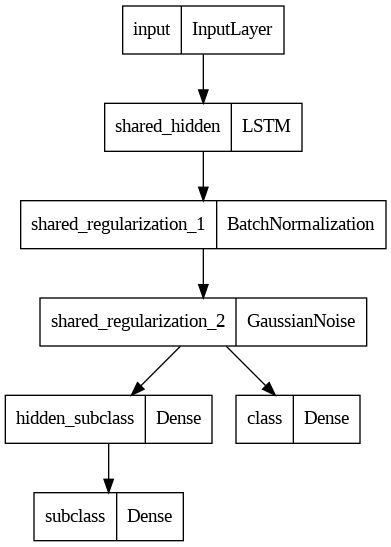

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile('adam',{'class':'binary_crossentropy','subclass':'categorical_crossentropy'},
              metrics={'class':['binary_accuracy','Precision','Recall','AUC'],'subclass':['categorical_accuracy','Precision','Recall','AUC']})

In [ ]:
model_history = model.fit({'input': x_train},
                            {'class': y_train, 'subclass': y_train1},
                            epochs=20, batch_size=35000, validation_data=({'input': x_test},{'class': y_test, 'subclass': y_test1}))

Epoch 1/20
76/76 [==============================] - 41s 483ms/step - loss: 2.2101 - class_loss: 0.6337 - subclass_loss: 1.5764 - class_binary_accuracy: 0.6951 - class_precision: 0.9560 - class_recall: 0.6969 - class_auc: 0.7358 - subclass_categorical_accuracy: 0.2604 - subclass_precision_1: 0.3690 - subclass_recall_1: 0.0297 - subclass_auc_1: 0.6500 - val_loss: 2.0380 - val_class_loss: 0.5733 - val_subclass_loss: 1.4647 - val_class_binary_accuracy: 0.9104 - val_class_precision: 0.9108 - val_class_recall: 0.9993 - val_class_auc: 0.8316 - val_subclass_categorical_accuracy: 0.8662 - val_subclass_precision_1: 0.0000e+00 - val_subclass_recall_1: 0.0000e+00 - val_subclass_auc_1: 0.9062
Epoch 2/20
76/76 [==============================] - 34s 451ms/step - loss: 1.7920 - class_loss: 0.4875 - subclass_loss: 1.3045 - class_binary_accuracy: 0.8545 - class_precision: 0.9695 - class_recall: 0.8673 - class_auc: 0.8347 - subclass_categorical_accuracy: 0.5195 - subclass_precision_1: 0.4475 - subclass_r

In [ ]:
model.evaluate({'input': x_train},
                            {'class': y_train, 'subclass': y_train1})

82803/82803 [==============================] - 267s 3ms/step - loss: 0.1980 - class_loss: 0.0960 - subclass_loss: 0.1020 - class_binary_accuracy: 0.9773 - class_precision: 0.9763 - class_recall: 0.9993 - class_auc: 0.9290 - subclass_categorical_accuracy: 0.9769 - subclass_precision_1: 0.9783 - subclass_recall_1: 0.9767 - subclass_auc_1: 0.9957


[0.19798655807971954,
 0.09597334265708923,
 0.10201466828584671,
 0.9772917032241821,
 0.9762507081031799,
 0.9993460774421692,
 0.9289662837982178,
 0.9769200086593628,
 0.9782946109771729,
 0.9766682386398315,
 0.9957002401351929]

In [ ]:
model.evaluate({'input': x_test},{'class': y_test, 'subclass': y_test1})

20701/20701 [==============================] - 69s 3ms/step - loss: 0.1971 - class_loss: 0.0955 - subclass_loss: 0.1016 - class_binary_accuracy: 0.9773 - class_precision: 0.9762 - class_recall: 0.9994 - class_auc: 0.9300 - subclass_categorical_accuracy: 0.9769 - subclass_precision_1: 0.9784 - subclass_recall_1: 0.9767 - subclass_auc_1: 0.9958


[0.19713720679283142,
 0.0954885333776474,
 0.10164865106344223,
 0.9773075580596924,
 0.976237952709198,
 0.9993776082992554,
 0.9300426840782166,
 0.9769211411476135,
 0.9783796668052673,
 0.9766840934753418,
 0.9957515001296997]

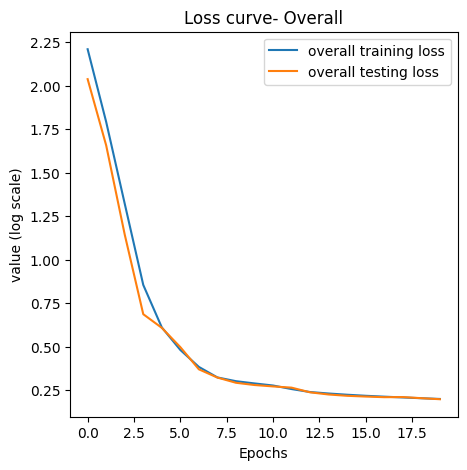

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Loss curve- Overall")
plt.plot(model_history.history["loss"], label="overall training loss")
plt.plot(model_history.history["val_loss"], label="overall testing loss")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

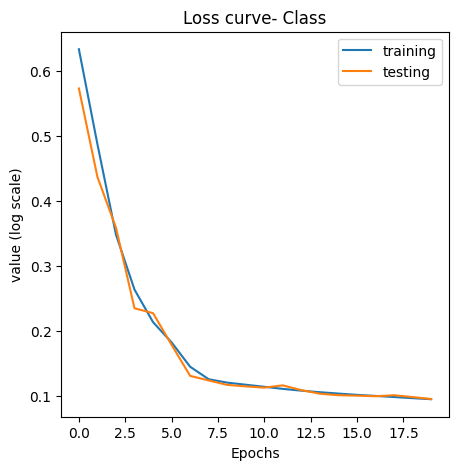

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Loss curve- Class")
plt.plot(model_history.history["class_loss"], label="training")
plt.plot(model_history.history["val_class_loss"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

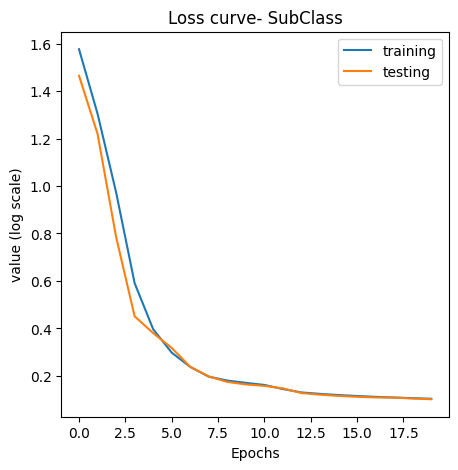

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Loss curve- SubClass")
plt.plot(model_history.history["subclass_loss"], label="training")
plt.plot(model_history.history["val_subclass_loss"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

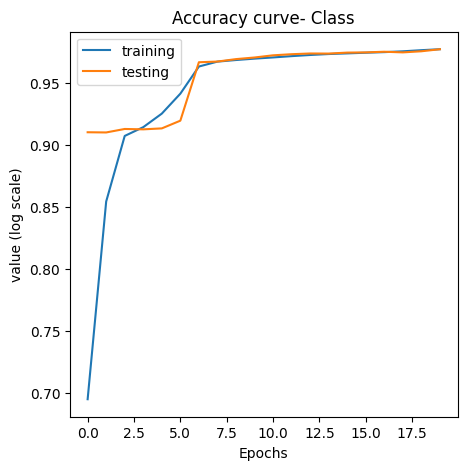

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Accuracy curve- Class")
plt.plot(model_history.history["class_binary_accuracy"], label="training")
plt.plot(model_history.history["val_class_binary_accuracy"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

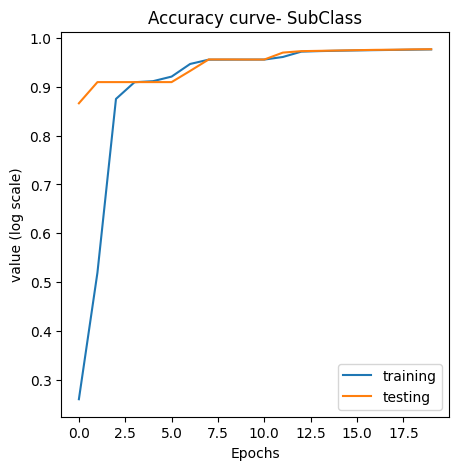

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Accuracy curve- SubClass")
plt.plot(model_history.history["subclass_categorical_accuracy"], label="training")
plt.plot(model_history.history["val_subclass_categorical_accuracy"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

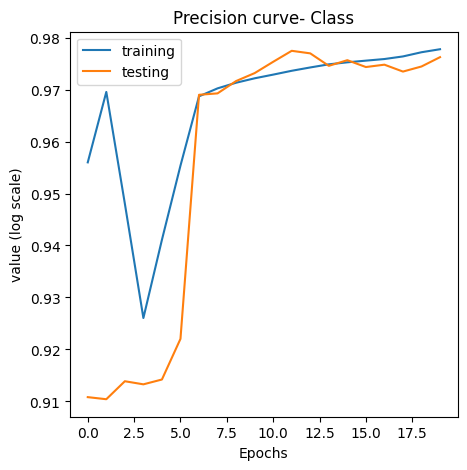

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Precision curve- Class")
plt.plot(model_history.history["class_precision"], label="training")
plt.plot(model_history.history["val_class_precision"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

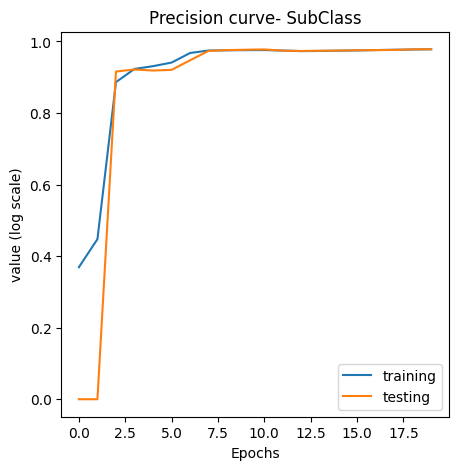

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Precision curve- SubClass")
plt.plot(model_history.history["subclass_precision_1"], label="training")
plt.plot(model_history.history["val_subclass_precision_1"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

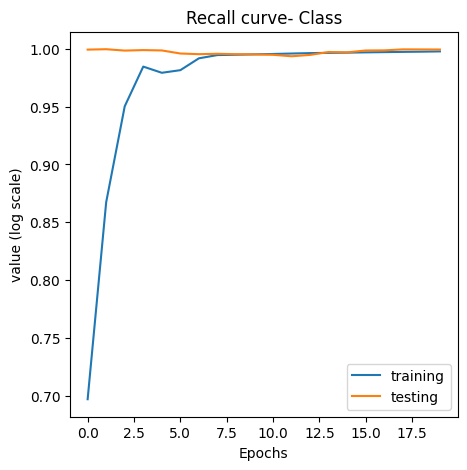

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Recall curve- Class")
plt.plot(model_history.history["class_recall"], label="training")
plt.plot(model_history.history["val_class_recall"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

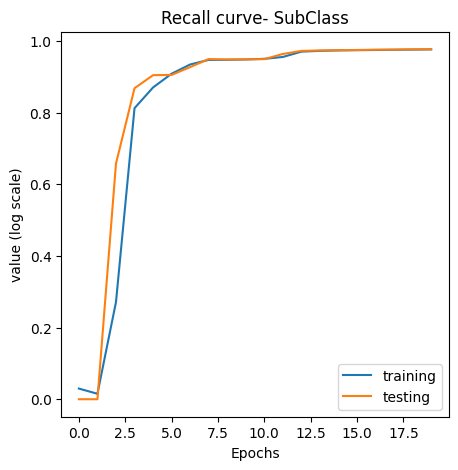

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("Recall curve- SubClass")
plt.plot(model_history.history["subclass_recall_1"], label="training")
plt.plot(model_history.history["val_subclass_recall_1"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

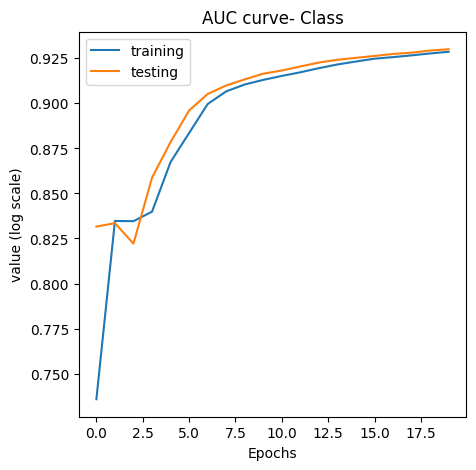

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("AUC curve- Class")
plt.plot(model_history.history["class_auc"], label="training")
plt.plot(model_history.history["val_class_auc"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

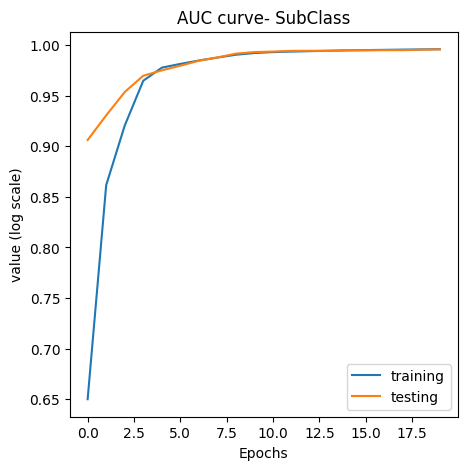

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("AUC curve- SubClass")
plt.plot(model_history.history["subclass_auc_1"], label="training")
plt.plot(model_history.history["val_subclass_auc_1"], label="testing")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

20701/20701 [==============================] - 54s 3ms/step
class classification CM-test


<Axes: >

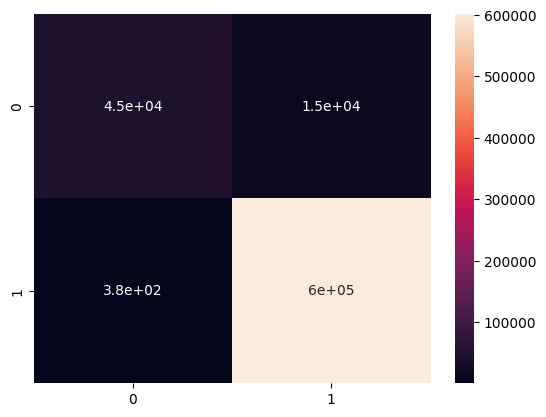

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred=model.predict(x_test)
y_pred_0 = (y_pred[0]>=0.5)
y_pred_1=y_pred[1]
y_pred_1= np.argmax(y_pred_1,axis=1)
y_test1= np.argmax(y_test1,axis=1)
print('class classification CM-test')
sns.heatmap(confusion_matrix(y_test,y_pred_0), annot=True)

subclass classification CM-test


<Axes: >

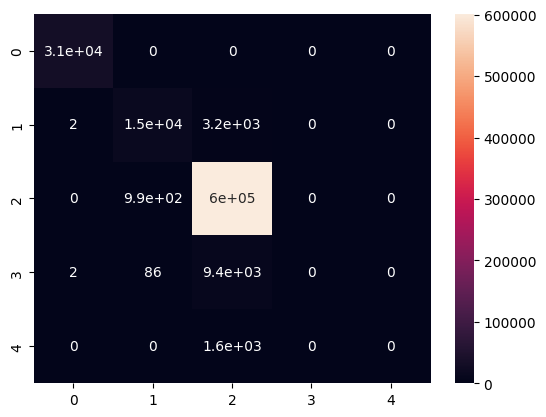

In [ ]:
print('subclass classification CM-test')
sns.heatmap(confusion_matrix(y_test1,y_pred_1), annot=True)

In [ ]:
print('classification report- class test')
print(classification_report(y_test,y_pred_0))

classification report- class test
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     59882
           1       0.98      1.00      0.99    602542

    accuracy                           0.98    662424
   macro avg       0.98      0.88      0.92    662424
weighted avg       0.98      0.98      0.98    662424



In [ ]:
print('classification report- subclass test')
print(classification_report(y_test1,y_pred_1))

classification report- subclass test


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30836
           1       0.93      0.82      0.87     17976
           2       0.98      1.00      0.99    602542
           3       0.00      0.00      0.00      9519
           4       0.00      0.00      0.00      1551

    accuracy                           0.98    662424
   macro avg       0.58      0.56      0.57    662424
weighted avg       0.96      0.98      0.97    662424



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
